In [ ]:
import os
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import seaborn as sns

from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'   # Windows 기본 한글 폰트
plt.rcParams['axes.unicode_minus'] = False      # 마이너스 깨짐 방지


In [ ]:
# =====================================================
# 파일 경로 설정 + CSV 로드
# =====================================================

def find_project_root() -> Path:
    p = Path.cwd()

    for parent in [p] + list(p.parents):
        if (parent / "data").exists() and (parent / "notebooks").exists():
            return parent

    return p

def latest_versioned_csv(folder: Path, base_name: str) -> Path | None:
    """
    base_name_v{n}.csv 중 최신 버전 반환
    """
    pattern = re.compile(rf"^{re.escape(base_name)}_v(\d+)\.csv$")
    best_v, best_path = None, None

    for f in folder.glob(f"{base_name}_v*.csv"):
        m = pattern.match(f.name)

        if m:
            v = int(m.group(1))

            if best_v is None or v > best_v:
                best_v, best_path = v, f

    return best_path

PROJECT_ROOT = find_project_root()

CLEAN_DIR = PROJECT_ROOT / "data" / "processed"

# 최신 버전 우선, 없으면 v1
channels_path = latest_versioned_csv(CLEAN_DIR, "channels_clean")
if channels_path is None:
    channels_path = CLEAN_DIR / "channels_clean_v1.csv"

trending_path = latest_versioned_csv(CLEAN_DIR, "trending_videos_clean")
if trending_path is None:
    trending_path = CLEAN_DIR / "youtube_trending_videos_clean_v1.csv"

EDA_FIG_DIR = PROJECT_ROOT / "figures" / "eda"
EDA_FIG_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("channels_path:", channels_path)
print("trending_path:", trending_path)
print("EDA figures will be saved to:", EDA_FIG_DIR)

if not channels_path.exists():
    raise FileNotFoundError(f"채널 clean 파일이 없습니다: {channels_path}")

if not Path(trending_path).exists():
    raise FileNotFoundError(f"트렌딩 clean 파일이 없습니다: {trending_path}")

yt_channels_df = pd.read_csv(channels_path, low_memory=False)
yt_trending_df = pd.read_csv(trending_path, low_memory=False)

print(f"채널 데이터 로딩 완료: {yt_channels_df.shape}")
print(f"트렌딩 데이터 로딩 완료: {yt_trending_df.shape}")
display(yt_trending_df.head(3))


PROJECT_ROOT: c:\Users\73bib\Desktop\유혜원\제주한라대학교\[2025] 프로젝트\bigdata_project\youtube_trending_ml
channels_path: c:\Users\73bib\Desktop\유혜원\제주한라대학교\[2025] 프로젝트\bigdata_project\youtube_trending_ml\data\processed\03_kaggle_clean\youtube_channels_clean_v1.csv
trending_path: c:\Users\73bib\Desktop\유혜원\제주한라대학교\[2025] 프로젝트\bigdata_project\youtube_trending_ml\data\processed\03_kaggle_clean\youtube_trending_videos_clean_v1.csv
EDA figures will be saved to: c:\Users\73bib\Desktop\유혜원\제주한라대학교\[2025] 프로젝트\bigdata_project\youtube_trending_ml\reports\figures\eda
채널 데이터 로딩 완료: (15830, 17)
트렌딩 데이터 로딩 완료: (2905678, 21)


,channelId,video_id,title,publishedAt,trending_date,categoryId,tags,view_count,likes,comment_count,...,tags_list,tags_count,trending_days,publish_month,publish_dayofweek,days_since_publish,like_ratio,comment_ratio,engagement_score,category_name
0,UCGfBwrCoi9ZJjKiUK8MmJNw,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11 22:21:49+00:00,2020-08-12 00:00:00+00:00,22,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,4500,...,"['pietro', 'guedes', 'ingrid', 'ohara', 'pingr...",14,7,8,1,0,0.322531,0.017056,0.339587,Unknown
1,UCaO6TYtlC8U5ttz62hTrZgg,jbGRowa5tIk,ITZY âNot Shyâ M/V TEASER,2020-08-11 15:00:13+00:00,2020-08-12 00:00:00+00:00,10,JYP Entertainment|JYP|ITZY|ìì§|ITZY Video|I...,6000070,714310,31040,...,"['JYP Entertainment', 'JYP', 'ITZY', 'ì\x9e\x8...",47,60,8,1,0,0.119050,0.005173,0.124224,Unknown
2,UCoXZmVma073v5G1cW82UKkA,3EfkCrXKZNs,Oh Juliana PARÃDIA - MC Niack,2020-08-10 14:59:00+00:00,2020-08-12 00:00:00+00:00,22,OH JULIANA PARÃDIA|MC Niack PARÃDIA|PARÃDIA...,2296748,39761,0,...,"['OH JULIANA PARÃ\x93DIA', 'MC Niack PARÃ\x93D...",7,6,8,0,1,0.017312,0.000000,0.017312,Unknown


In [ ]:
# =====================================================
# 채널/트렌딩 데이터 병합
# =====================================================

merged_df = pd.merge(
    yt_trending_df,
    yt_channels_df,
    left_on="channelId",
    right_on="channel_id",
    how="left"
)

print(f"병합 완료: {merged_df.shape}")


병합 완료: (2905678, 38)


In [ ]:
# =====================================================
# 기본 정보 확인
# =====================================================

print("=== 채널 데이터 정보 ===")
display(yt_channels_df.info())
display(yt_channels_df.head())

print("=== 트렌딩 데이터 정보 ===")
display(yt_trending_df.info())
display(yt_trending_df.head())

print("=== 병합 데이터 정보 ===")
display(merged_df.info())
display(merged_df.head())


=== 채널 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channel_id              15830 non-null  object 
 1   channel_name            15830 non-null  object 
 2   subscriber_count        15830 non-null  int64  
 3   view_count              15830 non-null  int64  
 4   video_count             15830 non-null  int64  
 5   created_date            14700 non-null  object 
 6   category                15722 non-null  object 
 7   country                 14030 non-null  object 
 8   videos_last_30_days     15830 non-null  int64  
 9   views_last_30_days      15830 non-null  int64  
 10  channel_age_days        14700 non-null  float64
 11  upload_frequency        14700 non-null  float64
 12  subscriber_per_view     15760 non-null  float64
 13  views_per_video         15756 non-null  float64
 14  uploads_per_subscrib

None

,channel_id,channel_name,subscriber_count,view_count,video_count,created_date,category,country,videos_last_30_days,views_last_30_days,channel_age_days,upload_frequency,subscriber_per_view,views_per_video,uploads_per_subscriber,category_encoded,country_encoded
0,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,99000000,39962585446,636,2016-06-29 03:15:23+00:00,"Music of Asia, Pop music, Music, Electronic music",KR,1,3256869,3450.0,0.184348,0.002477,6.283425e+07,0.000006,1916,56
1,UC3IZKseVpdzPSBaWxBxundA,HYBE LABELS,78700000,41604896923,2817,2008-06-04 08:23:22+00:00,"Hip hop music, Pop music, Music, Music of Asia",KR,79,46074833,6397.0,0.440363,0.001892,1.476922e+07,0.000036,1122,56
2,UCVNE660NcgYzi18LwwUZb7Q,BILLIE EILISH,82300,14316364,1,2019-01-18 05:14:32+00:00,NaN,NaN,0,0,2517.0,0.000397,0.005749,1.431636e+07,0.000012,3443,110
3,UCF1JIbMUs6uqoZEY1Haw0GQ,Shemaroo,60400000,27011004224,13374,2007-09-01 11:44:51+00:00,"Entertainment, Film",IN,63,10560897,6674.0,2.003896,0.002236,2.019665e+06,0.000221,482,47
4,UCYiGq8XF7YQD00x7wAd62Zg,JuegaGerman,54200000,17573028501,2368,2013-05-19 00:09:13+00:00,"Role-playing video game, Action game, Video ga...",CL,12,22980501,4587.0,0.516242,0.003084,7.421042e+06,0.000044,2671,18


=== 트렌딩 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905678 entries, 0 to 2905677
Data columns (total 21 columns):
 #   Column              Dtype  
---  ------              -----  
 0   channelId           object 
 1   video_id            object 
 2   title               object 
 3   publishedAt         object 
 4   trending_date       object 
 5   categoryId          int64  
 6   tags                object 
 7   view_count          int64  
 8   likes               int64  
 9   comment_count       int64  
 10  country             object 
 11  tags_list           object 
 12  tags_count          int64  
 13  trending_days       int64  
 14  publish_month       int64  
 15  publish_dayofweek   int64  
 16  days_since_publish  int64  
 17  like_ratio          float64
 18  comment_ratio       float64
 19  engagement_score    float64
 20  category_name       object 
dtypes: float64(3), int64(9), object(9)
memory usage: 465.5+ MB


None

,channelId,video_id,title,publishedAt,trending_date,categoryId,tags,view_count,likes,comment_count,...,tags_list,tags_count,trending_days,publish_month,publish_dayofweek,days_since_publish,like_ratio,comment_ratio,engagement_score,category_name
0,UCGfBwrCoi9ZJjKiUK8MmJNw,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11 22:21:49+00:00,2020-08-12 00:00:00+00:00,22,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,4500,...,"['pietro', 'guedes', 'ingrid', 'ohara', 'pingr...",14,7,8,1,0,0.322531,0.017056,0.339587,Unknown
1,UCaO6TYtlC8U5ttz62hTrZgg,jbGRowa5tIk,ITZY âNot Shyâ M/V TEASER,2020-08-11 15:00:13+00:00,2020-08-12 00:00:00+00:00,10,JYP Entertainment|JYP|ITZY|ìì§|ITZY Video|I...,6000070,714310,31040,...,"['JYP Entertainment', 'JYP', 'ITZY', 'ì\x9e\x8...",47,60,8,1,0,0.119050,0.005173,0.124224,Unknown
2,UCoXZmVma073v5G1cW82UKkA,3EfkCrXKZNs,Oh Juliana PARÃDIA - MC Niack,2020-08-10 14:59:00+00:00,2020-08-12 00:00:00+00:00,22,OH JULIANA PARÃDIA|MC Niack PARÃDIA|PARÃDIA...,2296748,39761,0,...,"['OH JULIANA PARÃ\x93DIA', 'MC Niack PARÃ\x93D...",7,6,8,0,1,0.017312,0.000000,0.017312,Unknown
3,UC6Xqz2pm50gDCORYztqhDpg,gBjox7vn3-g,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11 15:00:09+00:00,2020-08-12 00:00:00+00:00,20,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,2748,...,"['Riot', 'Riot Games', 'League of Legends', 'l...",42,6,8,1,0,0.153812,0.009144,0.162956,Unknown
4,UCEWOoncsrmirqnFqxer9lmA,npoUGx7UW7o,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11 20:04:02+00:00,2020-08-12 00:00:00+00:00,23,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,2751,...,"['The Noite', 'The Noite com Danilo Gentili', ...",22,6,8,1,0,0.067410,0.008407,0.075817,Unknown


=== 병합 데이터 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905678 entries, 0 to 2905677
Data columns (total 38 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   channelId               object 
 1   video_id                object 
 2   title                   object 
 3   publishedAt             object 
 4   trending_date           object 
 5   categoryId              int64  
 6   tags                    object 
 7   view_count_x            int64  
 8   likes                   int64  
 9   comment_count           int64  
 10  country_x               object 
 11  tags_list               object 
 12  tags_count              int64  
 13  trending_days           int64  
 14  publish_month           int64  
 15  publish_dayofweek       int64  
 16  days_since_publish      int64  
 17  like_ratio              float64
 18  comment_ratio           float64
 19  engagement_score        float64
 20  category_name           object 
 21  channel_id   

None

,channelId,video_id,title,publishedAt,trending_date,categoryId,tags,view_count_x,likes,comment_count,...,country_y,videos_last_30_days,views_last_30_days,channel_age_days,upload_frequency,subscriber_per_view,views_per_video,uploads_per_subscriber,category_encoded,country_encoded
0,UCGfBwrCoi9ZJjKiUK8MmJNw,s9FH4rDMvds,LEVEI UM FORA? FINGI ESTAR APAIXONADO POR ELA!,2020-08-11 22:21:49+00:00,2020-08-12 00:00:00+00:00,22,pietro|guedes|ingrid|ohara|pingrid|vlog|amigos...,263835,85095,4500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UCaO6TYtlC8U5ttz62hTrZgg,jbGRowa5tIk,ITZY âNot Shyâ M/V TEASER,2020-08-11 15:00:13+00:00,2020-08-12 00:00:00+00:00,10,JYP Entertainment|JYP|ITZY|ìì§|ITZY Video|I...,6000070,714310,31040,...,NaN,73.0,58464175.0,6528.0,0.391391,0.001223,9.982493e+06,0.000082,1897.0,110.0
2,UCoXZmVma073v5G1cW82UKkA,3EfkCrXKZNs,Oh Juliana PARÃDIA - MC Niack,2020-08-10 14:59:00+00:00,2020-08-12 00:00:00+00:00,22,OH JULIANA PARÃDIA|MC Niack PARÃDIA|PARÃDIA...,2296748,39761,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UC6Xqz2pm50gDCORYztqhDpg,gBjox7vn3-g,Contos de Runeterra: Targon | A Estrada Tortuosa,2020-08-11 15:00:09+00:00,2020-08-12 00:00:00+00:00,20,Riot|Riot Games|League of Legends|lol|trailer|...,300510,46222,2748,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UCEWOoncsrmirqnFqxer9lmA,npoUGx7UW7o,Entrevista com Thammy Miranda | The Noite (10/...,2020-08-11 20:04:02+00:00,2020-08-12 00:00:00+00:00,23,The Noite|The Noite com Danilo Gentili|Danilo ...,327235,22059,2751,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# =====================================================
# 결측치 확인
# =====================================================

print("=== 채널 결측치 ===")
display(yt_channels_df.isna().sum())

print("=== 트렌딩 결측치 ===")
display(yt_trending_df.isna().sum())

print("=== 병합 결측치 ===")
display(merged_df.isna().sum())


=== 채널 결측치 ===


channel_id                   0
channel_name                 0
subscriber_count             0
view_count                   0
video_count                  0
created_date              1130
category                   108
country                   1800
videos_last_30_days          0
views_last_30_days           0
channel_age_days          1130
upload_frequency          1130
subscriber_per_view         70
views_per_video             74
uploads_per_subscriber       0
category_encoded             0
country_encoded              0
dtype: int64

=== 트렌딩 결측치 ===


channelId             0
video_id              0
title                 0
publishedAt           0
trending_date         0
categoryId            0
tags                  0
view_count            0
likes                 0
comment_count         0
country               0
tags_list             0
tags_count            0
trending_days         0
publish_month         0
publish_dayofweek     0
days_since_publish    0
like_ratio            0
comment_ratio         0
engagement_score      0
category_name         0
dtype: int64

=== 병합 결측치 ===


channelId                       0
video_id                        0
title                           0
publishedAt                     0
trending_date                   0
categoryId                      0
tags                            0
view_count_x                    0
likes                           0
comment_count                   0
country_x                       0
tags_list                       0
tags_count                      0
trending_days                   0
publish_month                   0
publish_dayofweek               0
days_since_publish              0
like_ratio                      0
comment_ratio                   0
engagement_score                0
category_name                   0
channel_id                1918962
channel_name              1918962
subscriber_count          1918962
view_count_y              1918962
video_count               1918962
created_date              1993728
category                  1920028
country_y                 2076465
videos_last_30

In [ ]:
# =====================================================
# 채널별 트렌딩 영상 수 계산 및 추가
# =====================================================

# channelId → channel_id 통일
yt_trending_df = yt_trending_df.rename(columns={"channelId": "channel_id"})

# 채널별 트렌딩 영상 수
channel_trending_counts = (
    yt_trending_df
    .groupby("channel_id")["video_id"]
    .nunique()
    .reset_index(name="channel_trending_video_count")
)

# 채널 데이터에 병합
yt_channels_df = yt_channels_df.merge(
    channel_trending_counts,
    on="channel_id",
    how="left"
)

yt_channels_df["channel_trending_video_count"] = (
    yt_channels_df["channel_trending_video_count"].fillna(0)
)


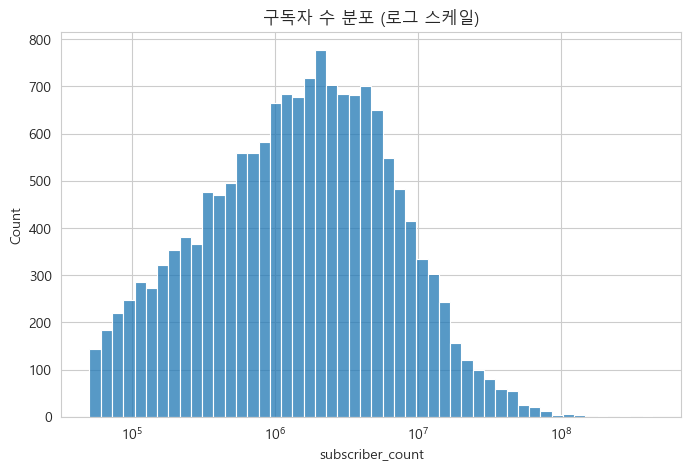

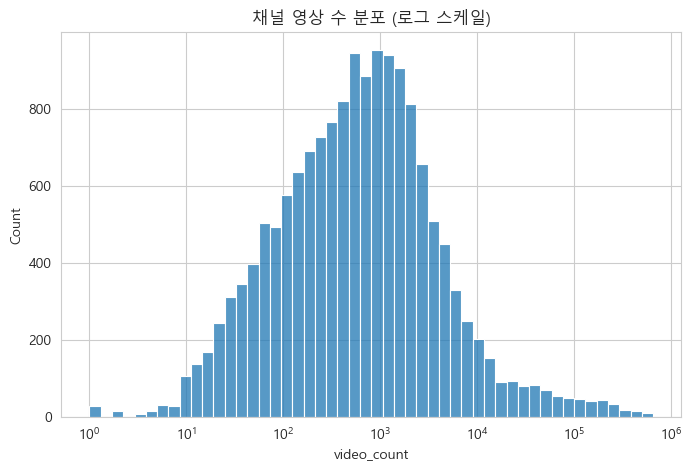

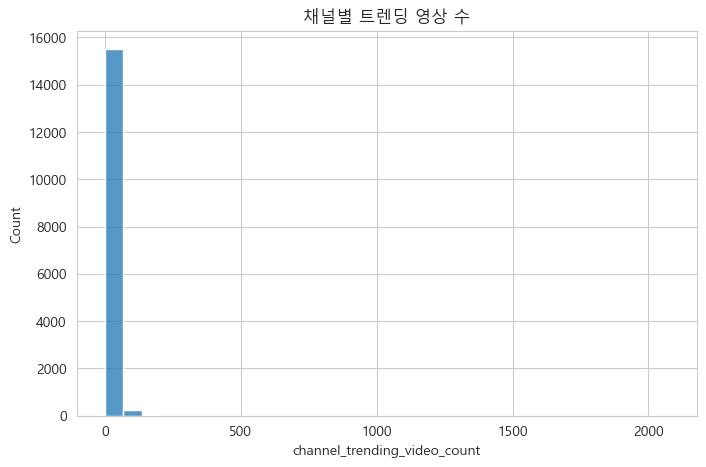

In [ ]:
# =====================================================
# 채널 규모 분포 시각화
# =====================================================

# 구독자 수 분포
plt.figure(figsize=(8,5))
sns.histplot(yt_channels_df["subscriber_count"], bins=50, log_scale=True)
plt.title("구독자 수 분포 (로그 스케일)")
plt.xlabel("subscriber_count")
plt.show()

# 채널 영상 수 분포
plt.figure(figsize=(8,5))
sns.histplot(yt_channels_df["video_count"], bins=50, log_scale=True)
plt.title("채널 영상 수 분포 (로그 스케일)")
plt.xlabel("video_count")
plt.show()

# 채널별 트렌딩 영상 수 분포
if "channel_trending_video_count" in yt_channels_df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(yt_channels_df["channel_trending_video_count"], bins=30)
    plt.title("채널별 트렌딩 영상 수")
    plt.show()


In [ ]:
# =====================================================
# 채널 성과 비율 확인
# =====================================================

if "channel_trending_ratio" in yt_channels_df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(yt_channels_df["channel_trending_ratio"], bins=30)
    plt.title("채널별 트렌딩 비율")
    plt.show()


In [ ]:
# =====================================================
# 카테고리·국가별 요약
# =====================================================

cat_summary = yt_channels_df.groupby("category").agg(
    avg_subscribers=("subscriber_count", "mean"),
    avg_views=("view_count", "mean"),
    avg_trending_ratio=("channel_trending_ratio", "mean") if "channel_trending_ratio" in yt_channels_df.columns else ("subscriber_count","mean"),
    count_channels=("channel_id", "count")
).sort_values("avg_trending_ratio", ascending=False)

print("카테고리별 요약 (상위 10):")
display(cat_summary.head(10))

country_summary = yt_channels_df.groupby("country").agg(
    avg_subscribers=("subscriber_count", "mean"),
    avg_views=("view_count", "mean"),
    avg_trending_ratio=("channel_trending_ratio", "mean") if "channel_trending_ratio" in yt_channels_df.columns else ("subscriber_count","mean"),
    count_channels=("channel_id", "count")
).sort_values("avg_trending_ratio", ascending=False)

print("국가별 요약 (상위 10):")
display(country_summary.head(10))


카테고리별 요약 (상위 10):


,avg_subscribers,avg_views,avg_trending_ratio,count_channels
category,,,,
"Music of Asia, Pop music, Music, Electronic music",9.900000e+07,3.996259e+10,9.900000e+07,1
"Hip hop music, Music, Pop music, Electronic music, Soul music, Rhythm and blues",7.630000e+07,3.594206e+10,7.630000e+07,1
"Music, Music of Asia, Film, Entertainment, Soul music",7.360000e+07,3.368513e+10,7.360000e+07,1
"Lifestyle (sociology), Pop music, Music of Asia, Music, Film",6.830000e+07,3.830118e+10,6.830000e+07,1
"Pop music, Music, Music of Asia, Electronic music, Hip hop music",6.415320e+07,6.416417e+10,6.415320e+07,5
"Sport, Lifestyle (sociology), Entertainment, Film",6.150000e+07,1.970004e+10,6.150000e+07,1
"Soul music, Pop music, Music of Asia, Music, Film",5.860000e+07,2.940033e+10,5.860000e+07,1
"Soul music, Pop music, Music, Music of Asia, Film",5.840000e+07,3.899103e+10,5.840000e+07,1
"Film, Pop music, Music of Asia, Music, Entertainment",5.441333e+07,3.519532e+10,5.441333e+07,3


국가별 요약 (상위 10):


,avg_subscribers,avg_views,avg_trending_ratio,count_channels
country,,,,
SV,2.726000e+07,9.507480e+09,2.726000e+07,2
JO,2.285000e+07,1.765409e+10,2.285000e+07,2
PR,1.916571e+07,1.366921e+10,1.916571e+07,7
AR,1.718558e+07,1.086992e+10,1.718558e+07,24
CO,1.359169e+07,9.965571e+09,1.359169e+07,16
KZ,1.319875e+07,7.845021e+09,1.319875e+07,4
MX,1.252779e+07,4.535866e+09,1.252779e+07,58
EC,1.178667e+07,1.987341e+09,1.178667e+07,3
CL,9.837645e+06,4.101842e+09,9.837645e+06,11


In [ ]:
# =====================================================
# 트렌딩 데이터 기반 추가 분석
# =====================================================

channel_perf = merged_df.groupby("channelId").agg(
    total_trending_videos=("video_id", "nunique"),
    total_views=("view_count_x", "sum") if "view_count_x" in merged_df.columns else ("view_count","sum"),
    total_likes=("likes", "sum"),
    total_comments=("comment_count", "sum"),
    avg_engagement=("engagement_score", "mean") if "engagement_score" in merged_df.columns else ("likes","mean")
).sort_values("total_trending_videos", ascending=False)

print("채널별 트렌딩 성과 (상위 10):")
display(channel_perf.head(10))


채널별 트렌딩 성과 (상위 10):


,total_trending_videos,total_views,total_likes,total_comments,avg_engagement
channelId,,,,,
UCvrhwpnp2DHYQ1CbXby9ypQ,2073,7401851708,150335927,6472983,0.020427
UCdubelOloxR3wzwJG9x8YqQ,1238,1097746837,38579863,4556839,0.047900
UC6-F5tO8uklgE9Zy8IvbdFw,1156,4892225970,78150393,2212593,0.016892
UCBnxEdpoZwstJqC1yZpOjRA,1082,8569018386,387320256,20189303,0.024103
UC55IWqFLDH1Xp7iu1_xknRA,1073,1817042929,27027882,634023,0.013482
UCNAf1k0yIjyGu3k9BwAg3lg,1070,3609825242,54985412,7259407,0.017181
UCtetJiD_llxdGL4Uh5-Oe2w,994,776202105,18238182,1817565,0.025236
UCjvgGbPPn-FgYeguc5nxG4A,983,11761288222,1097856941,43443568,0.097862
UCgCKagVhzGnZcuP9bSMgMCg,947,2920436249,99176557,8143096,0.037253


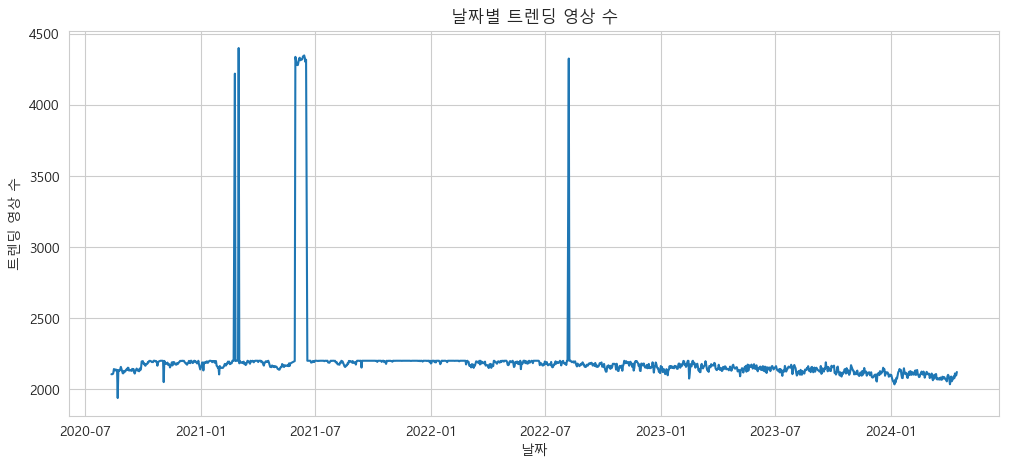

In [ ]:
# =====================================================
# 시계열 분석 (최근 트렌딩 추세)
# =====================================================

merged_df["trending_date_only"] = pd.to_datetime(merged_df["trending_date"]).dt.date
recent_trending = merged_df.groupby("trending_date_only").size()

plt.figure(figsize=(12,5))
recent_trending.plot(kind="line")
plt.title("날짜별 트렌딩 영상 수")
plt.ylabel("트렌딩 영상 수")
plt.xlabel("날짜")
plt.show()

In [ ]:
# =====================================================
# 영상 단위 성과 지표 생성
# =====================================================

yt_trending_df = yt_trending_df.copy()

# 조회수 0 → NA 처리
yt_trending_df["view_count_safe"] = yt_trending_df["view_count"].replace(0, pd.NA)

# 각종 반응률
yt_trending_df["engagement_rate"] = (
    yt_trending_df["likes"] + yt_trending_df["comment_count"]
) / yt_trending_df["view_count_safe"]
yt_trending_df["like_rate"] = yt_trending_df["likes"] / yt_trending_df["view_count_safe"]
yt_trending_df["comment_rate"] = yt_trending_df["comment_count"] / yt_trending_df["view_count_safe"]

yt_trending_df[
    ["video_id", "view_count", "likes", "comment_count", 
    "engagement_rate", "like_rate", "comment_rate"]
].head()


,video_id,view_count,likes,comment_count,engagement_rate,like_rate,comment_rate
0,s9FH4rDMvds,263835,85095,4500,0.339587,0.322531,0.017056
1,jbGRowa5tIk,6000070,714310,31040,0.124224,0.11905,0.005173
2,3EfkCrXKZNs,2296748,39761,0,0.017312,0.017312,0.0
3,gBjox7vn3-g,300510,46222,2748,0.162956,0.153812,0.009144
4,npoUGx7UW7o,327235,22059,2751,0.075817,0.06741,0.008407


In [ ]:
# =====================================================
# video_id 기준 영상 단위 성과 테이블
# =====================================================

video_metrics_df = (
    yt_trending_df
    .groupby("video_id")
    .agg(
        
        # 영상 기본 정보
        channel_id=("channelId", "first") if "channelId" in yt_trending_df.columns else ("channel_id", "first"),
        title=("title", "first"),
        country=("country", "first"),

        # 트렌딩 관련
        trending_days=("trending_days", "max"),   # 트렌딩 유지 일수
        max_views=("view_count", "max"),   # 트렌딩 기간 중 최대 조회수

        # 영상 단위 반응 지표 (평균)
        avg_engagement_rate=("engagement_rate", "mean"),
        avg_like_rate=("like_rate", "mean"),
        avg_comment_rate=("comment_rate", "mean")
    )
    .reset_index()
)

video_metrics_df.head()


,video_id,channel_id,title,country,trending_days,max_views,avg_engagement_rate,avg_like_rate,avg_comment_rate
0,---Pt7XVuOk,UC3PGilZDRq6wzd7mURXET2g,CHÃ REVELAÃÃO MENINO OU MENINA? *Quarta Gra...,BR,13,520256,0.08809,0.083322,0.004768
1,--0bCF-iK2E,UC6UL29enLNe4mqwTfAyeNuw,Jadon Sancho â¢ Magical Skills & Goals,GB,5,433340,0.029967,0.027191,0.002776
2,--0fND5o57I,UCvDpfkniGG6WkX5L7DwyGaA,On fait un tour aÌ bois XXXXL de 3 mÃ¨tres !,FR,6,81739,0.069446,0.067337,0.002109
3,--14w5SOEUs,UCGIelM2Dj3zza3xyV3pL3WQ,Migos - Avalanche,CA,51,8034045,0.055263,0.051679,0.003584
4,--1XTdLLpBo,UCcftUjNsimynCrKGFolLRKQ,Darum schlÃ¤gt China Deutschland! BYD Dolphin ...,DE,4,355979,0.022501,0.017965,0.004536


In [ ]:
# =====================================================
# 채널 구독자 수 병합
# =====================================================

video_metrics_with_channel = video_metrics_df.merge(
    yt_channels_df[["channel_id", "subscriber_count"]],
    on="channel_id",
    how="left"
)

video_metrics_with_channel[["video_id", "subscriber_count", "avg_engagement_rate"]].head()


,video_id,subscriber_count,avg_engagement_rate
0,---Pt7XVuOk,NaN,0.08809
1,--0bCF-iK2E,5440000.0,0.029967
2,--0fND5o57I,NaN,0.069446
3,--14w5SOEUs,1800000.0,0.055263
4,--1XTdLLpBo,NaN,0.022501


In [ ]:
# =====================================================
# 구독자 규모 그룹화 (소형/중형/대형)
# =====================================================

tmp = video_metrics_with_channel.dropna(subset=["subscriber_count", "avg_engagement_rate"]).copy()

tmp["subscriber_group"] = pd.qcut(
    tmp["subscriber_count"],
    q=3,   # 3개 구간 → 소형 / 중형 / 대형
    labels=["소형", "중형", "대형"]
)

tmp[["video_id", "subscriber_count", "subscriber_group", "avg_engagement_rate"]].head()


,video_id,subscriber_count,subscriber_group,avg_engagement_rate
1,--0bCF-iK2E,5440000.0,중형,0.029967
3,--14w5SOEUs,1800000.0,소형,0.055263
14,--47FjCWgrU,15400000.0,대형,0.012987
18,--5-brQiQFg,15400000.0,대형,0.013022
24,--89PwHsKJM,556000.0,소형,0.057674


C:\Users\73bib\AppData\Local\Temp\ipykernel_26708\1153626024.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("subscriber_group")


  subscriber_group avg_engagement median_engagement  n_videos
0               소형       0.053819          0.046108     40644
1               중형       0.055961          0.046449     40585
2               대형       0.056076          0.038731     40416


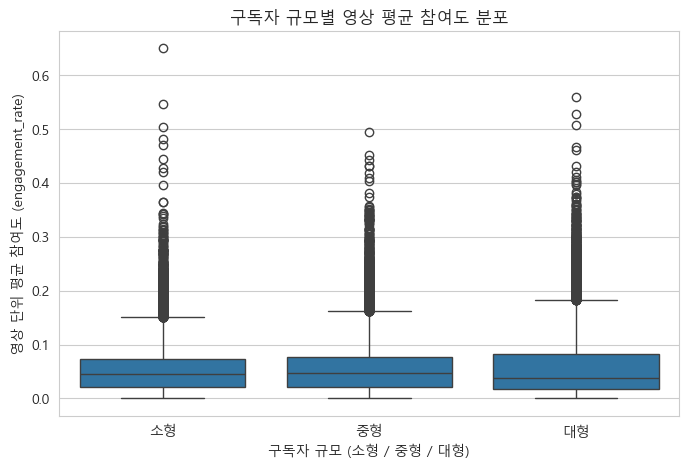

In [ ]:
# =====================================================
# 구독자 규모별 영상 참여도 분석
# =====================================================

subscriber_group_summary = (
    tmp
    .groupby("subscriber_group")
    .agg(
        avg_engagement=("avg_engagement_rate", "mean"),
        median_engagement=("avg_engagement_rate", "median"),
        n_videos=("video_id", "nunique")
    )
    .reset_index()
)

print(subscriber_group_summary)

plt.figure(figsize=(8,5))

sns.boxplot(
    data=tmp,
    x="subscriber_group",
    y="avg_engagement_rate"
)

plt.title("구독자 규모별 영상 평균 참여도 분포")
plt.xlabel("구독자 규모 (소형 / 중형 / 대형)")
plt.ylabel("영상 단위 평균 참여도 (engagement_rate)")
plt.show()


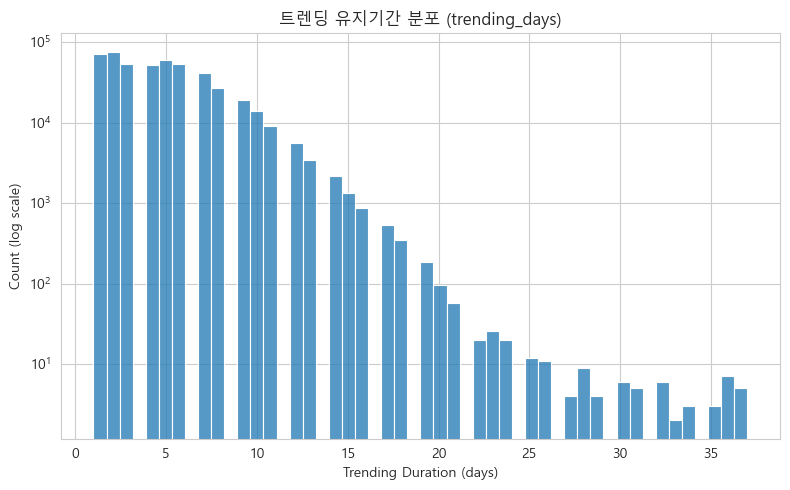

In [21]:
# =====================================================
# [EDA Figure 1] 트렌딩 유지기간(trending_days) 분포
# =====================================================

# video_id 기준 trending_days 계산
trending_days_df = (
    yt_trending_df
    .groupby("video_id")["trending_date"]
    .nunique()
    .reset_index(name="trending_days")
)

plt.figure(figsize=(8, 5))
sns.histplot(trending_days_df["trending_days"], bins=50)
plt.yscale("log")

plt.title("트렌딩 유지기간 분포 (trending_days)")
plt.xlabel("Trending Duration (days)")
plt.ylabel("Count (log scale)")

plt.tight_layout()
plt.savefig(EDA_FIG_DIR / "fig1_trending_days_distribution.png", dpi=300)
plt.show()


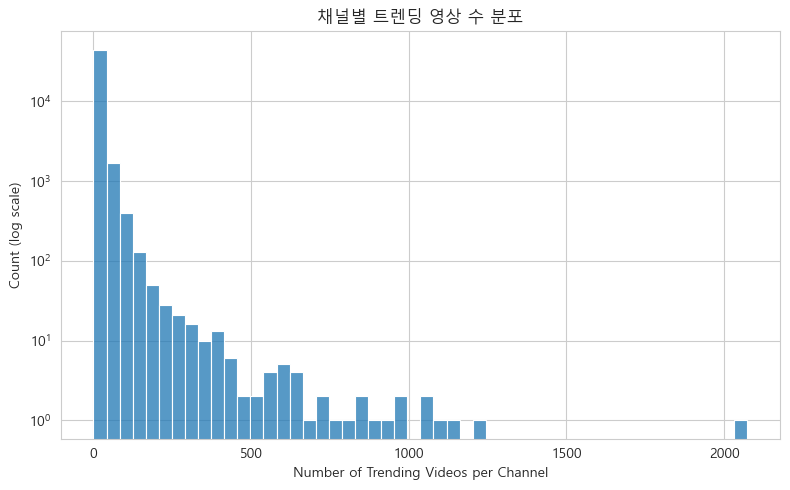

In [22]:
# =====================================================
# [EDA Figure 2] 채널별 트렌딩 영상 수 분포
# =====================================================

plt.figure(figsize=(8, 5))
sns.histplot(
    channel_trending_counts["channel_trending_video_count"],
    bins=50
)
plt.yscale("log")

plt.title("채널별 트렌딩 영상 수 분포")
plt.xlabel("Number of Trending Videos per Channel")
plt.ylabel("Count (log scale)")

plt.tight_layout()
plt.savefig(EDA_FIG_DIR / "fig2_channel_trending_video_distribution.png", dpi=300)
plt.show()
